# Sorry, Pandas Is Already Fast. You just Don't Know It Yet
## Let me open your eyes TODO
![](images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@photosbymishra?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Sourav Mishra</a>
        on 
        <a href='https://www.pexels.com/photo/grey-coupe-on-road-3136673/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

# Setup

In [1]:
import logging
import time
import warnings

import catboost as cb
import joblib
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S", level=logging.INFO
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

# Introduction

"Great... another article on how to make Pandas *n* times faster."

I think I have said that countless times for the past 2 years I have been using Pandas. The most recent one I saw literally said "make Pandas 71,803 times faster":

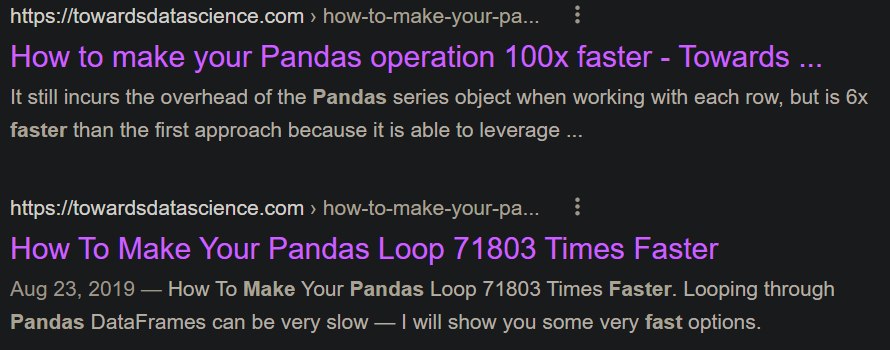
<figcaption style="text-align: center;">
    <strong>
        Like the dark mode?
    </strong>
</figcaption>

Obviously, I clicked on it and the article delivered the promise. But, I find it still ridiculous. Why?

Let me ask you this. Which hand do you use when I say "Touch your right ear". Of course the right hand. You wouldn't touch your right ear by putting your left hand over your head. That would be stupid. 

Well, choosing the slowest way to do something and then, showing the fastest - the right way to do it is absolute silliness. So, comparing those functions which the Pandas documentation clearly states slow to the fastest ones is not fair - it is trickery. 

That's why this article will show you the best practices of some of the most common data manipulation operations in Pandas, not just how to loop faster. You can even consider these best practices as "common sense" because that's how the creator of Pandas intended his library to be used.

# Indexing efficiently

Let's start with the most basic operations. Specifically, we will see the fastest way of selecting rows and columns. As you know, there are two indexing operators - `loc` and `iloc` in Pandas. Even though their difference won't matter much for small datasets, they will be quite noticeable as data size increases.

Firstly, for choosing a row or multiple rows, `iloc` is faster. 

In [3]:
adult_income = pd.read_csv("data/adult.csv")
adult_income.shape

(48842, 15)

In [22]:
# Choose rows
adult_income.iloc[range(10000)]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,66,Self-emp-not-inc,176315,Bachelors,13,Divorced,Sales,Not-in-family,White,Male,401,0,20,United-States,<=50K
9996,35,Private,187167,HS-grad,9,Never-married,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
9997,24,Private,241582,Some-college,10,Never-married,Sales,Not-in-family,White,Male,0,0,33,United-States,<=50K
9998,31,Private,247328,11th,7,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,<=50K


In contrast, `loc` does best for choosing columns with their labels:

In [21]:
adult_income.loc[:, ["age", "workclass", "education"]]

,age,workclass,education
0,25,Private,11th
1,38,Private,HS-grad
2,28,Local-gov,Assoc-acdm
3,44,Private,Some-college
4,18,?,Some-college
...,...,...,...
48837,27,Private,Assoc-acdm
48838,40,Private,HS-grad
48839,58,Private,HS-grad
48840,22,Private,HS-grad


For sampling columns or rows, the built-in `sample` function is the fastest. You may think that sampling using random indices with NumPy would be faster but NumPy functions are not always the fastest:

In [29]:
# Sampling rows
adult_income.sample(7, axis=0)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
46089,33,Private,231413,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,M,0,0,40,United-States,<=50K
8044,47,Private,192713,HS-grad,9,Married-civ-spouse,Sales,Husband,White,M,0,0,50,United-States,>50K
27150,29,Private,244395,11th,7,Never-married,Other-service,Unmarried,Black,F,0,0,40,United-States,<=50K
29044,20,Private,282579,Some-college,10,Never-married,Other-service,Not-in-family,White,M,0,0,40,United-States,<=50K
7769,61,Private,438587,5th-6th,3,Married-civ-spouse,Machine-op-inspct,Husband,Black,M,0,0,40,United-States,<=50K
4051,45,Private,163174,11th,7,Married-civ-spouse,Machine-op-inspct,Husband,White,M,4386,0,40,United-States,>50K
26008,30,Private,375827,HS-grad,9,Never-married,Handlers-cleaners,Other-relative,White,M,0,0,40,United-States,<=50K


In [18]:
# Sampling 5 columns and 7 rows
adult_income.sample(5, axis=1).sample(7, axis=0)

,hours-per-week,educational-num,education,income,race
29228,40,10,Some-college,<=50K,Black
6543,40,9,HS-grad,>50K,White
21939,40,12,Assoc-acdm,>50K,White
2502,35,10,Some-college,<=50K,White
37723,40,11,Assoc-voc,<=50K,Black
9207,40,10,Some-college,<=50K,White
18002,70,9,HS-grad,<=50K,White


# Replacing values efficiently

Most of the time, I see people using `loc` or `iloc` to replace specific values in a DataFrame:

In [23]:
adult_income.loc[adult_income["workclass"] == "?", "workclass"] = np.nan

True, this method seems the fastest because we are specifying the exact location of the value to be replaced instead of letting Pandas search it. However, this method is clumsy and not as fast as `replace`:

In [25]:
adult_income.replace(to_replace="?", value=np.nan, inplace=True)

While the speed is the first benefit of `replace`, the second is its flexibility. Above, we replaced all question marks with `NaN` - an operation that would take multiple calls with index-based replacement. 

Also, `replace` allows using lists or dictionaries to change multiple values simultaneously:

In [26]:
adult_income.replace(["Male", "Female"], ["M", "F"], inplace=True)

When replacing a list of values with another, they will have one-to-one, index-to-index mapping. You can even be more specific with dictionaries like so:

In [28]:
adult_income.replace({"United States": "USA", "US": "USA"}, inplace=True)

It is possible to go even more granular with nested dictionaries:

In [30]:
adult_income.replace(
    {
        "education": {"HS-grad": "High school", "Some-college": "College"},
        "income": {"<=50K": 0, ">50K": 1},
    },
    inplace=True,
)

Nested replacement helps when you only want to affect values of specific columns. Here, we are replacing values only in `education` and `income` columns. 

There are other benefits of `replace`, including regex-based replacement, which can be read in the [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html).

# Iterating efficiently

The golden rule when it comes to applying operations on entire columns or data frames is to *never use loops*. That's the cliché advice that works. But, I get it - how do you manipulate entire arrays without looping?

The trick is to start thinking about arrays as vectors and the whole data frame as a matrix. After all, that's how ML models accept the data - to put it bluntly, they are all multivariable vector-valued functions.

And from linear algebra, we know that operations on vectors get carried out on the entire vector, whether it is multiplication, addition, etc. Fortunately, this idea of operating on mathematical vectors is implemented in Pandas and NumPy as vectorization.

So, if you want to perform any type of mathematical operation on one or more columns, there is a good chance that the operation is vectorized in Pandas. For example, the builtin Python operators like +, -, \*, /, \** work just like on vectors. 

To get a taste of vectorization, let's perform some operations on a massive dataset. We will chose ~1M row dataset of Kaggle TPS September competition:

In [37]:
import datatable as dt

tps = dt.fread("data/train.csv").to_pandas()
tps.shape

(957919, 120)

Let's perform some mathematical operations on a few columns with Pandas `apply` function. That's the fastest built-in iterator of Pandas.

In [38]:
def crazy_function(col1, col2, col3):
    return np.sqrt(col1 ** 3 + col2 ** 2 + col3 * 10)

We will apply this function on 3 columns with `apply` and check the runtime:

In [43]:
# f3, f56 are column names
%time tps['f1000'] = tps.apply(lambda row: crazy_function(row['f1'], row['f56'], row['f44']), axis=1)

Wall time: 20.7 s


20.7 seconds for 1M row dataset. Not bad. Now, watch what happens when we pass columns as vectors rather than scalars. No need to modify the function:

In [45]:
%time tps['f1001'] = crazy_function(tps['f1'], tps['f56'], tps['f44'])

Wall time: 34 ms


34 milliseconds! That's about 600 times faster. But we can do even better - vectorization is even faster when used on NumPy arrays:

In [48]:
%time tps['f1001'] = crazy_function(tps['f1'].values, tps['f56'].values, tps['f44'].values)

Wall time: 32 ms


Just add `.values` to get the underlying NumPy ndarray of Pandas Series. The reason NumPy arrays are faster is that they don't perform additional calls for indexing, data type checking like Pandas Series.